# Assignment 2


In [1]:
#importing required libraries for the assignment
import findspark
findspark.init()
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.mllib.feature import StandardScaler, PCA
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, count, isnan, when
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

## a) Discover and visualise the data

In [2]:
# Create a basic SparkSession by using SparkSession.builder
spark = SparkSession.builder.appName('csci316 grpasg2').getOrCreate()
spark

In [3]:
# Import and read the dataset
df = spark.read.csv('train.csv', header = True, inferSchema = True)
df.show()

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+---------------+-------------------+--------+------------+-----------+-------------+-----------+---------------+---------+-------------+-----------+-----------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+-------------+-----------------+---------------+-------------------+-------------+-----------------+-----------+---------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+------------------------+---------------+------------------

In [4]:
# Check schema of dataset
df.printSchema()

root
 |-- number_of_elements: integer (nullable = true)
 |-- mean_atomic_mass: double (nullable = true)
 |-- wtd_mean_atomic_mass: double (nullable = true)
 |-- gmean_atomic_mass: double (nullable = true)
 |-- wtd_gmean_atomic_mass: double (nullable = true)
 |-- entropy_atomic_mass: double (nullable = true)
 |-- wtd_entropy_atomic_mass: double (nullable = true)
 |-- range_atomic_mass: double (nullable = true)
 |-- wtd_range_atomic_mass: double (nullable = true)
 |-- std_atomic_mass: double (nullable = true)
 |-- wtd_std_atomic_mass: double (nullable = true)
 |-- mean_fie: double (nullable = true)
 |-- wtd_mean_fie: double (nullable = true)
 |-- gmean_fie: double (nullable = true)
 |-- wtd_gmean_fie: double (nullable = true)
 |-- entropy_fie: double (nullable = true)
 |-- wtd_entropy_fie: double (nullable = true)
 |-- range_fie: double (nullable = true)
 |-- wtd_range_fie: double (nullable = true)
 |-- std_fie: double (nullable = true)
 |-- wtd_std_fie: double (nullable = true)
 |-- mea

In [5]:
#convert spark dataframe to pandas 
pdDf= df.toPandas()
pdDf

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


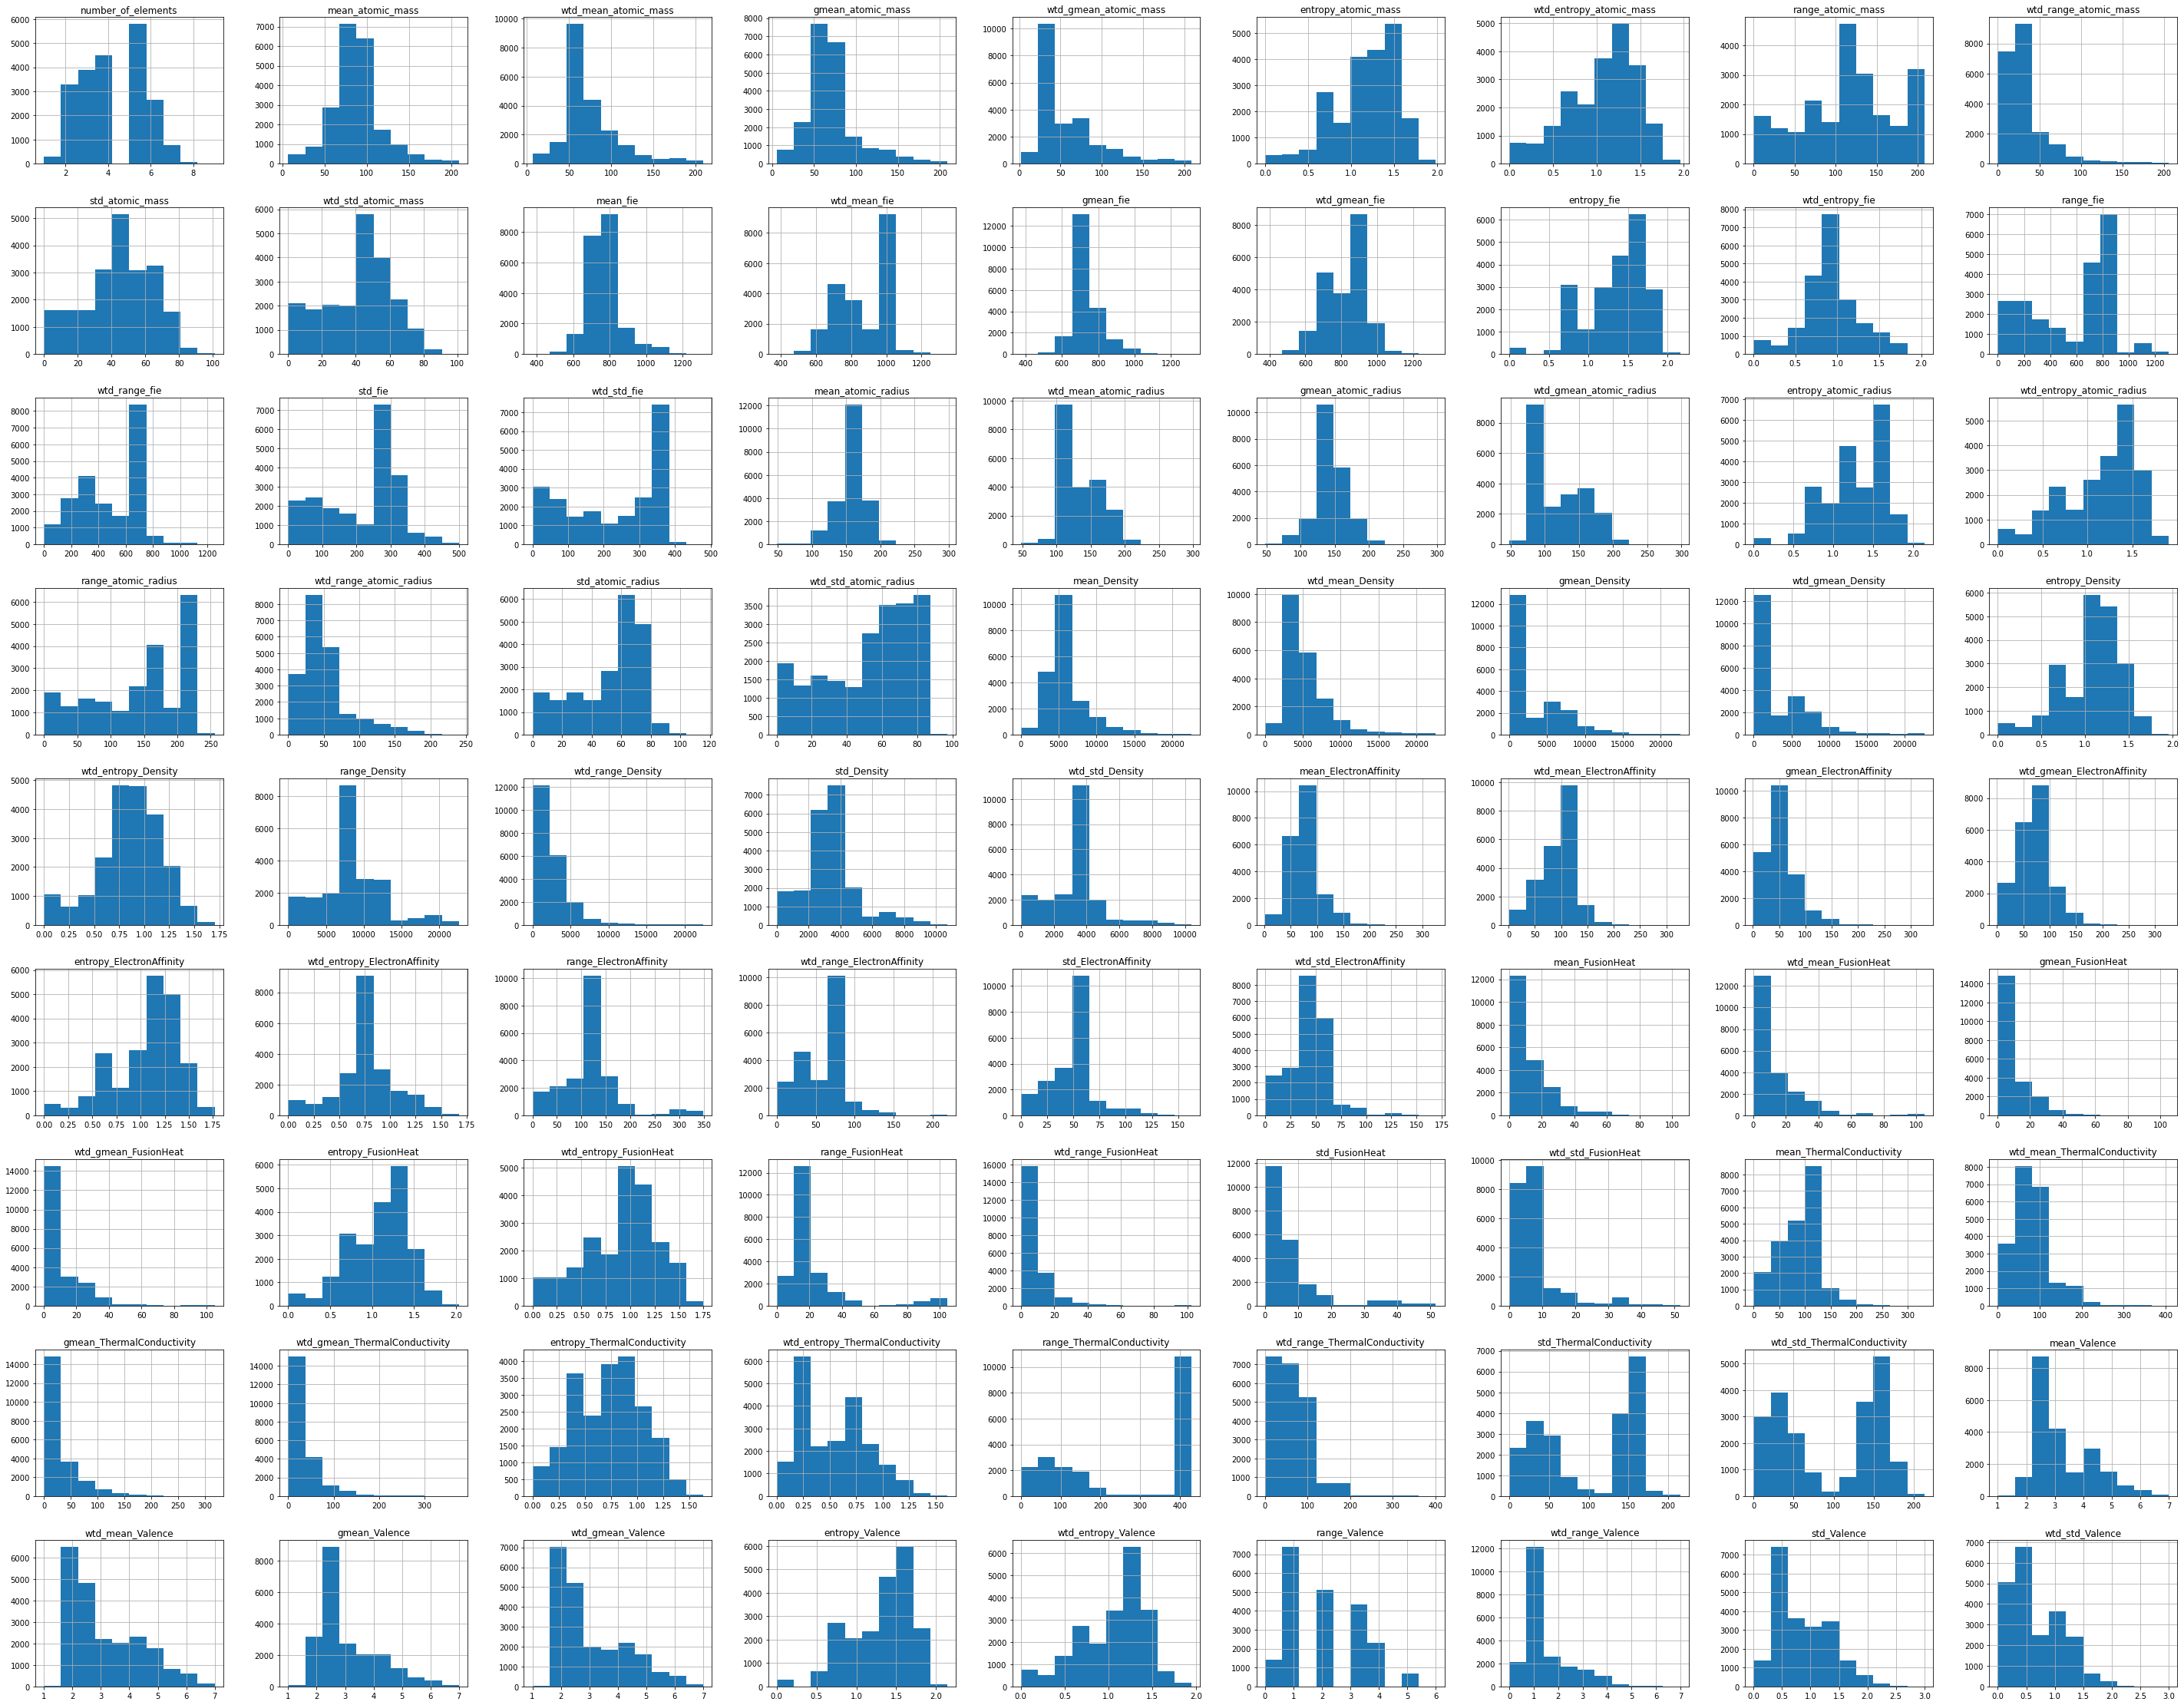

In [6]:
# Shows how each features is being distributed according to which values has the highest count and check for outliers
features=pdDf.iloc[:,:-1]
features.hist(figsize=(50,40))
plt.show()

In [7]:
# Getting each column summary stats
for i in df.columns:
    df[[i]].describe().show()

+-------+------------------+
|summary|number_of_elements|
+-------+------------------+
|  count|             21263|
|   mean| 4.115223627898227|
| stddev|1.4392946521289955|
|    min|                 1|
|    max|                 9|
+-------+------------------+

+-------+-----------------+
|summary| mean_atomic_mass|
+-------+-----------------+
|  count|            21263|
|   mean|87.55763086578581|
| stddev|29.67649726343945|
|    min|            6.941|
|    max|         208.9804|
+-------+-----------------+

+-------+--------------------+
|summary|wtd_mean_atomic_mass|
+-------+--------------------+
|  count|               21263|
|   mean|    72.9883104433944|
| stddev|   33.49040622089571|
|    min|            6.423452|
|    max|            208.9804|
+-------+--------------------+

+-------+-----------------+
|summary|gmean_atomic_mass|
+-------+-----------------+
|  count|            21263|
|   mean|71.29062703785543|
| stddev|31.03027167743376|
|    min|      5.320573171|
|    max|

+-------+------------------+
|summary|  wtd_mean_Density|
+-------+------------------+
|  count|             21263|
|   mean| 5267.188547245276|
| stddev|3221.3145057873535|
|    min|             1.429|
|    max|           22590.0|
+-------+------------------+

+-------+-----------------+
|summary|    gmean_Density|
+-------+-----------------+
|  count|            21263|
|   mean|3460.692235231457|
| stddev|3703.256369745445|
|    min|            1.429|
|    max|          22590.0|
+-------+-----------------+

+-------+------------------+
|summary| wtd_gmean_Density|
+-------+------------------+
|  count|             21263|
|   mean|3117.2411099818128|
| stddev|3975.1225874449888|
|    min|       0.686244596|
|    max|           22590.0|
+-------+------------------+

+-------+------------------+
|summary|   entropy_Density|
+-------+------------------+
|  count|             21263|
|   mean|1.0724246063952867|
| stddev|0.3423562910085326|
|    min|               0.0|
|    max|       1.95

+-------+----------------------------+
|summary|wtd_mean_ThermalConductivity|
+-------+----------------------------+
|  count|                       21263|
|   mean|           81.54907964079713|
| stddev|           45.51925596742993|
|    min|                     0.02658|
|    max|                      406.96|
+-------+----------------------------+

+-------+-------------------------+
|summary|gmean_ThermalConductivity|
+-------+-------------------------+
|  count|                    21263|
|   mean|        29.84172738948145|
| stddev|       34.059581099039754|
|    min|                  0.02658|
|    max|              317.8836265|
+-------+-------------------------+

+-------+-----------------------------+
|summary|wtd_gmean_ThermalConductivity|
+-------+-----------------------------+
|  count|                        21263|
|   mean|           27.308061297047594|
| stddev|            40.19114954541609|
|    min|                  0.022951557|
|    max|                  376.0328776|
+--

## b) Prepare the data for machine learning algorithmns

#### We decided to drop all rows that contains 0 so we convert all 0 to null and remove rows with null.

In [8]:
# replacing all 0 to null values for all columns
df=df.select([when(col(c)==0,None).otherwise(col(c)).alias(c) for c in df.columns])
df.show()

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+---------------+-------------------+--------+------------+-----------+-------------+-----------+---------------+---------+-------------+-----------+-----------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+-------------+-----------------+---------------+-------------------+-------------+-----------------+-----------+---------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+------------------------+---------------+------------------

In [9]:
# Checking for null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+---------------+-------------------+--------+------------+---------+-------------+-----------+---------------+---------+-------------+-------+-----------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+-------------+-----------------+---------------+-------------------+-------------+-----------------+-----------+---------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+------------------------+---------------+-------------------+----

In [10]:
# Dropping any rows that has null values
df = df.na.drop(how = 'any')
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------------+----------------+--------------------+-----------------+---------------------+-------------------+-----------------------+-----------------+---------------------+---------------+-------------------+--------+------------+---------+-------------+-----------+---------------+---------+-------------+-------+-----------+------------------+----------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+-----------------+---------------------+------------+----------------+-------------+-----------------+---------------+-------------------+-------------+-----------------+-----------+---------------+---------------------+-------------------------+----------------------+--------------------------+------------------------+----------------------------+----------------------+--------------------------+--------------------+------------------------+---------------+-------------------+----

In [11]:
# getting all features excluding target variable critical_temp
features = df.drop('critical_temp')

In [12]:
# We need to convert dataframe into an RDD to check for correlation
colName = features.columns
featuresRDD = features.rdd
# hide the output with ';' as the output has too many data
featuresRDD.collect();

In [13]:
featuresRDD = features.rdd.map(lambda row: row[0:])
# hide the output with ';' as the output has too many data
featuresRDD.collect();

In [14]:
summary = Statistics.colStats(featuresRDD)
print(summary.mean())
print(summary.variance())
print(summary.numNonzeros())
print(summary.normL1())

[4.23455106e+00 8.61331448e+01 7.11827708e+01 6.94664022e+01
 5.62946759e+01 1.20102975e+00 1.09665620e+00 1.18278530e+02
 3.27898424e+01 4.51679394e+01 4.23941308e+01 7.70264718e+02
 8.76560307e+02 7.36885407e+02 8.37400661e+02 1.33790739e+00
 9.53358616e-01 5.94422369e+02 4.94046936e+02 2.23472307e+02
 2.32479497e+02 1.57517155e+02 1.33216461e+02 1.43457842e+02
 1.18979422e+02 1.30548450e+00 1.16788015e+00 1.44362690e+02
 5.07968575e+01 5.33746174e+01 5.41767514e+01 5.93274422e+03
 5.08703768e+03 3.20129391e+03 2.85936875e+03 1.10441071e+00
 8.78928448e-01 8.81124652e+03 2.87996436e+03 3.45529687e+03
 3.37986011e+03 7.69690475e+01 9.36236878e+01 5.37962321e+01
 7.27944913e+01 1.10386591e+00 7.93900927e-01 1.25035487e+02
 6.07604560e+01 5.04025144e+01 4.57530847e+01 1.40878076e+01
 1.36233671e+01 9.73487542e+00 9.74211055e+00 1.12503589e+00
 9.41947814e-01 2.20149071e+01 8.30989930e+00 8.63405893e+00
 8.01888830e+00 8.97387491e+01 8.16400087e+01 2.82382180e+01
 2.55832660e+01 7.473036

In [15]:
# Checking correlation using pearson method
corrMat = Statistics.corr(featuresRDD, method = 'pearson')
corrDf = pd.DataFrame(corrMat)
corrDf.index, corrDf.columns = colName, colName

corrDf.columns
corrDf.index
corrDf


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
number_of_elements,1.000000,-0.092597,-0.318286,-0.242049,-0.420506,0.938389,0.869331,0.659389,-0.361371,0.481111,...,-0.618228,-0.659823,-0.621002,-0.667678,0.973737,0.882741,0.124937,-0.528600,-0.033798,-0.091642
mean_atomic_mass,-0.092597,1.000000,0.790503,0.933976,0.712911,-0.050754,-0.034241,0.192866,0.452713,0.263283,...,0.358744,0.277704,0.375529,0.293463,-0.108899,-0.090445,-0.037239,0.152112,0.000614,-0.014537
wtd_mean_atomic_mass,-0.318286,0.790503,1.000000,0.822941,0.959568,-0.273589,-0.382521,-0.092187,0.759778,-0.007970,...,0.534946,0.547479,0.536642,0.548242,-0.347637,-0.288190,0.056537,0.348653,0.106352,0.185299
gmean_atomic_mass,-0.242049,0.933976,0.822941,1.000000,0.832963,-0.120174,-0.160141,-0.121300,0.470549,-0.070322,...,0.473163,0.404018,0.497270,0.426272,-0.253275,-0.250460,-0.088518,0.277094,-0.033245,-0.040579
wtd_gmean_atomic_mass,-0.420506,0.712911,0.959568,0.832963,1.000000,-0.327529,-0.448249,-0.313296,0.713815,-0.235904,...,0.600751,0.617921,0.606308,0.625169,-0.449007,-0.406699,0.022089,0.442693,0.084671,0.141708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wtd_entropy_Valence,0.882741,-0.090445,-0.288190,-0.250460,-0.406699,0.839332,0.902416,0.652394,-0.465821,0.497629,...,-0.570536,-0.660864,-0.566696,-0.670357,0.897412,1.000000,0.087905,-0.761831,-0.062615,-0.046703
range_Valence,0.124937,-0.037239,0.056537,-0.088518,0.022089,0.066342,0.042276,0.160005,0.059125,0.158697,...,0.182156,0.204660,0.045433,0.124339,0.011113,0.087905,1.000000,0.132152,0.967910,0.841706
wtd_range_Valence,-0.528600,0.152112,0.348653,0.277094,0.442693,-0.469179,-0.651635,-0.431225,0.577308,-0.337675,...,0.591330,0.733984,0.570000,0.734899,-0.547546,-0.761831,0.132152,1.000000,0.220157,0.155101
std_Valence,-0.033798,0.000614,0.106352,-0.033245,0.084671,-0.088289,-0.095317,0.068486,0.115333,0.098988,...,0.284964,0.301816,0.145748,0.222257,-0.152246,-0.062615,0.967910,0.220157,1.000000,0.863564


In [16]:
# Find mutually correalated features values that are more than 0.8 
mutually_correlated_features = set() 
for i in range(len(corrDf.columns)):  
    for j in range(i):
        if (corrDf.iloc[i, j]) > 0.8:
            colname = corrDf.columns[i]

            mutually_correlated_features.add(colname)

print(len(mutually_correlated_features))


53


In [17]:
# Drop mutually correalated features values that are more than 0.8 
df2=df.drop(*(mutually_correlated_features))
df2.printSchema()

root
 |-- number_of_elements: integer (nullable = true)
 |-- mean_atomic_mass: double (nullable = true)
 |-- wtd_mean_atomic_mass: double (nullable = true)
 |-- range_atomic_mass: double (nullable = true)
 |-- wtd_range_atomic_mass: double (nullable = true)
 |-- mean_fie: double (nullable = true)
 |-- wtd_mean_fie: double (nullable = true)
 |-- wtd_entropy_fie: double (nullable = true)
 |-- range_fie: double (nullable = true)
 |-- wtd_range_fie: double (nullable = true)
 |-- mean_atomic_radius: double (nullable = true)
 |-- wtd_mean_atomic_radius: double (nullable = true)
 |-- wtd_range_atomic_radius: double (nullable = true)
 |-- mean_Density: double (nullable = true)
 |-- range_Density: double (nullable = true)
 |-- mean_ElectronAffinity: double (nullable = true)
 |-- wtd_mean_ElectronAffinity: double (nullable = true)
 |-- range_ElectronAffinity: double (nullable = true)
 |-- mean_FusionHeat: double (nullable = true)
 |-- range_FusionHeat: double (nullable = true)
 |-- mean_ThermalC

In [18]:
# Number of columns in dataframe
len(df2.columns)

29

## c) Select and train models
We decided to use linear regression, random forest regressor and decision tree regressor alogorithm.

In [19]:
# As critical_temp is the attribute we want to predict. Hence it is the label and is excluded from the features
features = df2.drop('critical_temp')

In [20]:
# Assemble all the features together using VectorAssembler
assembler = VectorAssembler(inputCols=features.columns, outputCol='features')
output = assembler.transform(df2).select('features','critical_temp')
output.show(truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|features                                                                                                                                                                                                                                                                            |critical_temp|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|[4.0,88.9444675,57.86269229,122.90607,31.79492086,775.425,1010.268571,0.791487788,810.6,735.9857143,160.25,105.5142857,4

In [21]:
# split 2/3 and 1/3 records in the df2 for training and test
(train,test)=output.randomSplit([0.67,0.33])
train.show()
test.show()

+--------------------+-------------+
|            features|critical_temp|
+--------------------+-------------+
|[2.0,25.5545,13.3...|          8.5|
|[2.0,25.5545,13.3...|         17.8|
|[2.0,25.5545,13.3...|         18.0|
|[2.0,25.5545,13.3...|         18.7|
|[2.0,25.5545,13.3...|         19.3|
|[2.0,48.73925,13....|         29.0|
|[2.0,48.73925,14....|         29.0|
|[2.0,48.73925,15....|         28.0|
|[2.0,48.73925,15....|         28.4|
|[2.0,48.73925,15....|         28.6|
|[2.0,48.73925,15....|         29.8|
|[2.0,48.73925,16....|         29.0|
|[2.0,72.45807595,...|         29.5|
|[2.0,74.66885,23....|          7.0|
|[2.0,81.18535,18....|          8.0|
|[2.0,85.468025,18...|          5.4|
|[2.0,92.53235,19....|          6.0|
|[3.0,23.60246667,...|        12.15|
|[3.0,38.61559333,...|          5.5|
|[3.0,39.63346667,...|          1.7|
+--------------------+-------------+
only showing top 20 rows

+--------------------+-------------+
|            features|critical_temp|
+-----------

#### Liner regression

In [22]:
# Using LinearRegression from spark ML to predict
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'critical_temp')
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [5.005157475564584,0.3292763914409441,-0.13819146419203007,0.08162462413353078,-0.08052988887265511,0.054325318429695686,0.044410886584506454,-20.485189161408098,-0.0007536316802607785,0.01357497073458502,-0.09722362852632542,0.59889863632759,-0.26800779991656987,-0.004401254485272401,-0.00014605750830823809,-0.030089787500759375,-0.21387284284008246,0.03650054963833435,0.2718770936714456,-0.14430719774536999,0.17149973251131956,0.2187697089931275,-0.3250135170331409,5.4955356327829445,7.445224597985219,0.021343980367077603,-3.7670092832126763,4.85735740440655]
Intercept: -122.32809933105639


In [23]:
# Summarize the model over the training set
trainSummary = lr_model.summary
print('RMSE: %f' % trainSummary.rootMeanSquaredError)
print('\nr2: %f' % trainSummary.r2)

RMSE: 20.516816

r2: 0.624612


In [24]:
# Use model to predict our test set
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","critical_temp","features").show()

+-------------------+-------------+--------------------+
|         prediction|critical_temp|            features|
+-------------------+-------------+--------------------+
|-2.8968637328844267|         12.8|[2.0,25.5545,13.3...|
|-2.8968637328844267|         13.0|[2.0,25.5545,13.3...|
|-2.8968637328844267|         19.5|[2.0,25.5545,13.3...|
|-2.8968637328844267|         20.0|[2.0,25.5545,13.3...|
|  11.73218673196672|        12.25|[2.0,48.73925,15....|
|  11.73218673196672|         29.5|[2.0,48.73925,15....|
|  11.73218673196672|         30.0|[2.0,48.73925,15....|
| 41.629086310843434|         14.7|[3.0,16.33572309,...|
|  5.528730786909534|          5.0|[3.0,38.61559333,...|
|  40.71838733885278|         28.0|[3.0,72.81695667,...|
|  40.71213271623168|         43.0|[3.0,72.81695667,...|
|  40.63643844388346|         28.0|[3.0,72.81695667,...|
|  40.63643844388346|         41.2|[3.0,72.81695667,...|
|  42.29689737151392|         47.0|[4.0,46.5409508,4...|
| 34.956814334912565|         2

#### Random Forest Regressor

In [25]:
# Using Random Forest Regressor from spark ML to predict
from pyspark.ml.regression import RandomForestRegressor
rfReg = RandomForestRegressor(featuresCol = 'features', labelCol = 'critical_temp')
rf_model = rfReg.fit(train)

In [26]:
# Use model to predict our test set
rf_predictions = rf_model.transform(test)
rf_predictions.show()

+--------------------+-------------+------------------+
|            features|critical_temp|        prediction|
+--------------------+-------------+------------------+
|[2.0,25.5545,13.3...|         12.8|16.212962542848352|
|[2.0,25.5545,13.3...|         13.0|16.212962542848352|
|[2.0,25.5545,13.3...|         19.5|16.212962542848352|
|[2.0,25.5545,13.3...|         20.0|16.212962542848352|
|[2.0,48.73925,15....|        12.25| 17.57580808362748|
|[2.0,48.73925,15....|         29.5| 17.57580808362748|
|[2.0,48.73925,15....|         30.0| 17.57580808362748|
|[3.0,16.33572309,...|         14.7|16.313717908873617|
|[3.0,38.61559333,...|          5.0|12.929754948673416|
|[3.0,72.81695667,...|         28.0|28.005446904096534|
|[3.0,72.81695667,...|         43.0|28.005446904096534|
|[3.0,72.81695667,...|         28.0|28.005446904096534|
|[3.0,72.81695667,...|         41.2|28.005446904096534|
|[4.0,46.5409508,4...|         47.0| 63.87552827864128|
|[4.0,60.36015982,...|         28.0|25.289188629

#### DecisionTree

In [27]:
# Using Decision Tree Regressor from spark ML to predict
from pyspark.ml.regression import DecisionTreeRegressor
dtReg = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'critical_temp')
dt_model = dtReg.fit(train)

In [28]:
dt_predictions = dt_model.transform(test)
dt_predictions.select("prediction", "critical_temp", "features").show()

+------------------+-------------+--------------------+
|        prediction|critical_temp|            features|
+------------------+-------------+--------------------+
|25.961018604651166|         12.8|[2.0,25.5545,13.3...|
|25.961018604651166|         13.0|[2.0,25.5545,13.3...|
|25.961018604651166|         19.5|[2.0,25.5545,13.3...|
|25.961018604651166|         20.0|[2.0,25.5545,13.3...|
|25.961018604651166|        12.25|[2.0,48.73925,15....|
|25.961018604651166|         29.5|[2.0,48.73925,15....|
|25.961018604651166|         30.0|[2.0,48.73925,15....|
| 9.981077844311372|         14.7|[3.0,16.33572309,...|
|7.9065968000000035|          5.0|[3.0,38.61559333,...|
|21.235340647857885|         28.0|[3.0,72.81695667,...|
|21.235340647857885|         43.0|[3.0,72.81695667,...|
|21.235340647857885|         28.0|[3.0,72.81695667,...|
|21.235340647857885|         41.2|[3.0,72.81695667,...|
| 67.00308409387226|         47.0|[4.0,46.5409508,4...|
|29.063669696969697|         28.0|[4.0,60.360159

## d) Fine tune the models
#### Using Crossvalidator and Paramgrid from SparkMLlib to fine tune our models

##### For crossValidator, we decided to use three fold split as the model selection and the true error rate computation can be carried out simultaneously. The error rate estimate of the final model on validation data will be biased (smaller than the true error rate) since the validation set is used to select the final model. Hence a third independent part of the data, the test data, is required. 

In [29]:
# LinearRegression fine tuning using paramgrid and crossvalidation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
lrparamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.001, 0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10, 20, 50])
             .build())

In [30]:
#Create 3-fold CrossValidator
lrcv = CrossValidator(estimator = lr,
                      estimatorParamMaps = lrparamGrid,
                      evaluator = RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction"),
                      numFolds = 3)

In [31]:
#Run cross validations
lrcv_model = lrcv.fit(train)

In [32]:
# Model summary statistics
lrcv_summary = lrcv_model.bestModel.summary
print("Coefficient Standard Errors: " + str(lrcv_summary.coefficientStandardErrors))
print("P Values: " + str(lrcv_summary.pValues)) 

Coefficient Standard Errors: [0.6269944981445508, 0.026824411241319453, 0.030491867291472557, 0.007530038167823752, 0.022154871333466, 0.007663975071469822, 0.007028476277370803, 2.4985938634841545, 0.0020374953795758628, 0.0036232442232636075, 0.029015690576364325, 0.03329854077127515, 0.01684605227735443, 0.00022654217968206208, 8.567320878419737e-05, 0.018793594718057083, 0.0170694035771383, 0.005596191014292723, 0.043359930155071044, 0.018346740401525098, 0.023422078338359315, 0.009651287982804112, 0.018504298418054815, 1.9096177888324286, 1.5434902565512338, 0.007810663437492425, 0.2205120222103643, 0.4241427248500017, 6.733800694342675]
P Values: [3.1086244689504383e-15, 0.0, 1.2253264942030384e-05, 0.0, 0.00017313358601445117, 1.000532989792191e-12, 5.721916274126215e-10, 4.440892098500626e-16, 0.736272701255926, 0.0001822534028097511, 0.0014356484426332194, 0.0, 0.0, 0.0, 0.08172510240248587, 0.0977789904566464, 0.0, 7.878808716554886e-11, 4.998736979899832e-10, 3.9968028886505

In [33]:
# Test set so we can measure the accuracy of our model on new data
lrcv_predictions = lrcv_model.transform(test)

In [34]:
lrcv_predictions.select("prediction", "critical_temp", "features").show()

+------------------+-------------+--------------------+
|        prediction|critical_temp|            features|
+------------------+-------------+--------------------+
|-2.801032489298848|         12.8|[2.0,25.5545,13.3...|
|-2.801032489298848|         13.0|[2.0,25.5545,13.3...|
|-2.801032489298848|         19.5|[2.0,25.5545,13.3...|
|-2.801032489298848|         20.0|[2.0,25.5545,13.3...|
| 11.81505080706799|        12.25|[2.0,48.73925,15....|
| 11.81505080706799|         29.5|[2.0,48.73925,15....|
| 11.81505080706799|         30.0|[2.0,48.73925,15....|
|41.609284462970805|         14.7|[3.0,16.33572309,...|
| 5.527712249907907|          5.0|[3.0,38.61559333,...|
| 40.69204574763046|         28.0|[3.0,72.81695667,...|
| 40.68594289322127|         43.0|[3.0,72.81695667,...|
|40.612097064529706|         28.0|[3.0,72.81695667,...|
|40.612097064529706|         41.2|[3.0,72.81695667,...|
| 42.31408796540322|         47.0|[4.0,46.5409508,4...|
| 35.00703568940514|         28.0|[4.0,60.360159

In [35]:
# Decision Tree Regressor fine tuning using paramgrid and crossvalidation
dt_paramGrid = (ParamGridBuilder()
             .addGrid(dtReg.maxDepth, [2, 5, 10, 20])
             .addGrid(dtReg.maxBins, [10, 20, 40, 80])
             .build())

In [36]:
# Create 3-fold CrossValidator
dtcv = CrossValidator(estimator = dtReg,
                      estimatorParamMaps = dt_paramGrid,
                      evaluator = RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction"),
                      numFolds = 3)

In [37]:
# Run cross validations
dtcv_model = dtcv.fit(train)

In [38]:
# Test set so we can measure the accuracy of our model on new data
dtcv_prediction = dtcv_model.transform(test)

In [39]:
dtcv_prediction.select("prediction", "critical_temp", "features").show()

+-----------------+-------------+--------------------+
|       prediction|critical_temp|            features|
+-----------------+-------------+--------------------+
|             17.8|         12.8|[2.0,25.5545,13.3...|
|             17.8|         13.0|[2.0,25.5545,13.3...|
|             17.8|         19.5|[2.0,25.5545,13.3...|
|             17.8|         20.0|[2.0,25.5545,13.3...|
|28.05454545454546|        12.25|[2.0,48.73925,15....|
|28.05454545454546|         29.5|[2.0,48.73925,15....|
|28.05454545454546|         30.0|[2.0,48.73925,15....|
|             14.7|         14.7|[3.0,16.33572309,...|
|16.39999999999999|          5.0|[3.0,38.61559333,...|
|             39.5|         28.0|[3.0,72.81695667,...|
|             39.5|         43.0|[3.0,72.81695667,...|
|            35.25|         28.0|[3.0,72.81695667,...|
|            35.25|         41.2|[3.0,72.81695667,...|
|             43.0|         47.0|[4.0,46.5409508,4...|
|             20.0|         28.0|[4.0,60.36015982,...|
|         

In [40]:
# Random Forest Regressor fine tuning using paramgrid and crossvalidation
rfparamGrid = (ParamGridBuilder()
               .addGrid(rfReg.maxDepth, [2, 5, 10])
               .addGrid(rfReg.maxBins, [5, 10, 20])
               .addGrid(rfReg.numTrees, [5, 20, 50])
             .build())


In [41]:
# Create 3-fold CrossValidator
rfcv = CrossValidator(estimator = rfReg,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction"),
                      numFolds = 3)

In [42]:
# Run cross validations
rfcv_model = rfcv.fit(train)

In [43]:
# Test set so we can measure the accuracy of our model on new data
rfcv_prediction = rfcv_model.transform(test)

In [44]:
rfcv_prediction.select("prediction", "critical_temp", "features").show()

+------------------+-------------+--------------------+
|        prediction|critical_temp|            features|
+------------------+-------------+--------------------+
|18.314609868172365|         12.8|[2.0,25.5545,13.3...|
|18.314609868172365|         13.0|[2.0,25.5545,13.3...|
|18.314609868172365|         19.5|[2.0,25.5545,13.3...|
|18.314609868172365|         20.0|[2.0,25.5545,13.3...|
|26.624044817242186|        12.25|[2.0,48.73925,15....|
|26.624044817242186|         29.5|[2.0,48.73925,15....|
|26.624044817242186|         30.0|[2.0,48.73925,15....|
|13.720324104154713|         14.7|[3.0,16.33572309,...|
| 8.898972643529383|          5.0|[3.0,38.61559333,...|
| 34.82046787281345|         28.0|[3.0,72.81695667,...|
| 34.82046787281345|         43.0|[3.0,72.81695667,...|
| 34.44103824805941|         28.0|[3.0,72.81695667,...|
| 34.44103824805941|         41.2|[3.0,72.81695667,...|
| 49.01892530302074|         47.0|[4.0,46.5409508,4...|
| 19.80511266621851|         28.0|[4.0,60.360159

## e) Evalulate the outcomes
#### Evalulating the models by getting the RMSE and R2 on each models that we build and after we did the fine tuning.
#### We can see that the difference before and after for our linear regression model has not much different, but however after the fine tuning, for our random forest and decision tree model we can see a slightly lower RMSE and higher R2 . Random Forest and Decision Tree regressor seems to be the best model after fine tuning.

In [45]:
# Evalulate lr_model over test set
test_result = lr_model.evaluate(test)
print("RMSE:%g " % test_result.rootMeanSquaredError)
print('R Squared (R2) on test data = %g' % test_result.r2)

RMSE:20.6951 
R Squared (R2) on test data = 0.626846


In [46]:
# Uses the best lr model found from the Cross Validation
# Evaluate best lr model after fine tuning
print('RMSE:', RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction",metricName="rmse")
      .evaluate(lrcv_predictions))
print('R2',RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction",metricName="r2")
      .evaluate(lrcv_predictions))

RMSE: 20.695433050845757
R2 0.6268337618701438


In [47]:
# Evalulate rf model over test set
print('RMSE:',RegressionEvaluator(predictionCol="prediction", labelCol="critical_temp", metricName="rmse")
      .evaluate(rf_predictions))
print('R2:',RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction",metricName="r2")
      .evaluate(rf_predictions))

RMSE: 17.096247826002422
R2: 0.7453434113478796


In [48]:
# Uses the best rf model found from the Cross Validation
# Evaluate best rf model
print('RMSE:', RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction",metricName="rmse")
      .evaluate(rfcv_prediction))
print('R2:', RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction",metricName="r2")
      .evaluate(rfcv_prediction))

RMSE: 12.538578201010626
R2: 0.8630222924998261


In [49]:
# Evalulate dt model over test set
print('RMSE:', RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction", metricName="rmse")
      .evaluate(dt_predictions))
print('R2:', RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction", metricName="r2")
      .evaluate(dt_predictions))

RMSE: 17.312334308460937
R2: 0.7388653107972143


In [50]:
# Uses the best dt model found from the Cross Validation
# Evaluate best dt model
print('RMSE:', RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction",metricName="rmse")
      .evaluate(dtcv_prediction))
# Evaluate model
print('R2:', RegressionEvaluator(labelCol="critical_temp", predictionCol="prediction",metricName="r2")
      .evaluate(dtcv_prediction))

RMSE: 12.775721088813954
R2: 0.8577919597138586
